In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ebhhsaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
tweets_df = pd.read_csv('Datasets/trump_tweets.csv')
tweets_df.head(20)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,A GREAT DAY IN ARIZONA! https://t.co/jsohSb5QF6,06-24-2020 04:26:29,19259.0,87048,false,1.275646e+18
1,Twitter for iPhone,It is ashame that Congress doesn’t do somethin...,06-24-2020 03:49:10,27893.0,148055,false,1.275637e+18
2,Twitter for iPhone,Tomorrow @SenatorTimScott and the Senate Repub...,06-24-2020 03:30:26,14197.0,57121,false,1.275632e+18
3,Twitter for iPhone,BIG VICTORY for patients – Federal court UPHOL...,06-24-2020 01:21:21,41496.0,176760,false,1.275600e+18
4,Twitter for iPhone,RT @WhiteHouse: LIVE: POTUS delivers an addres...,06-23-2020 22:33:15,11124.0,0,true,1.275558e+18
5,Twitter for iPhone,RT @WhiteHouse: President @realDonaldTrump is ...,06-23-2020 19:32:26,10693.0,0,true,1.275512e+18
6,Twitter for iPhone,RT @TeamTrump: President @realDonaldTrump: We ...,06-23-2020 19:32:26,7327.0,0,true,1.275512e+18
7,Twitter for iPhone,RT @KellyannePolls: #SchoolChoice gives parent...,06-23-2020 19:31:56,8976.0,0,true,1.275512e+18
8,Twitter for iPhone,RT @TeamTrump: President @realDonaldTrump will...,06-23-2020 19:27:55,10241.0,0,true,1.275511e+18
9,Twitter for iPhone,RT @TeamTrump: Governor of Arizona Doug Ducey ...,06-23-2020 19:25:52,8238.0,0,true,1.275510e+18


In [36]:
en_stop_words = set(stopwords.words('english'))
print(en_stop_words)

{'should', 'further', 'myself', 'couldn', 'are', 'again', 'herself', 'below', 'between', 'do', 'nor', 'his', 'have', 'it', 'only', 'was', 'aren', 'too', 'over', 'after', 'how', 'needn', 'wouldn', 'you', 'as', 'these', "shouldn't", 'through', 'under', 'by', 'here', 'where', 'her', 'off', "aren't", "isn't", 'can', 'about', 'very', "you'd", 'when', 'having', 'ours', 'but', 'hadn', 'that', 'which', 'few', 'won', 'were', 'such', 'ain', 'hers', "mightn't", 'before', 'with', 'is', 'than', "you'll", 'he', 'doesn', "haven't", 'mightn', 'those', 'himself', 'itself', 'whom', 'your', "hadn't", "won't", 'ourselves', 's', 'theirs', "hasn't", 'then', 'to', 'both', "should've", 'm', 'been', 'did', 'an', 'don', 'ma', "couldn't", 'didn', 'now', 'during', 'for', 'or', 'had', 'down', 'yourself', 'other', "that'll", 'being', 'mustn', 'own', 'be', 'any', 'the', 'yours', 'why', 'some', 'me', 'our', 'who', 'o', 'hasn', 'wasn', 'shan', 'each', "shan't", 'there', "don't", 'isn', 'once', 'i', "wasn't", 'll', 'th

In [35]:
def clean_tweets(df=tweets_df, tweet_col='text', date_col='created_at', start_datetime=datetime(2020,1,20, 0, 0, 0)):
    df_copy = df.copy()
    df_copy.dropna(inplace=True) # drop rows with empty values
    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S')) # format the date
    df_copy = df_copy[df_copy[date_col] >=start_datetime] # filter rows older than a given date
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower() # lower the tweets
    
    #filter out stop words and URLs
    en_stop_words = set(stopwords.words('english')) 
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }

    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word))]))

    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))

    return df_copy

  
df_tweets = pd.read_csv('Datasets/trump_tweets.csv')
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()
    

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,preprocessed_text,tokenized_text
0,Twitter for iPhone,A GREAT DAY IN ARIZONA! https://t.co/jsohSb5QF6,2020-06-24 04:26:29,19259.0,87048,false,1.275646e+18,great day arizona!,"[great, day, arizona]"
1,Twitter for iPhone,It is ashame that Congress doesn’t do somethin...,2020-06-24 03:49:10,27893.0,148055,false,1.275637e+18,ashame congress doesn’t something lowlifes bur...,"[ashame, congress, doesn, something, lowlifes,..."
2,Twitter for iPhone,Tomorrow @SenatorTimScott and the Senate Repub...,2020-06-24 03:30:26,14197.0,57121,false,1.275632e+18,tomorrow @senatortimscott senate republicans g...,"[tomorrow, senatortimscott, senate, republican..."
3,Twitter for iPhone,BIG VICTORY for patients – Federal court UPHOL...,2020-06-24 01:21:21,41496.0,176760,false,1.275600e+18,big victory patients – federal court upholds h...,"[big, victory, patients, federal, court, uphol..."
4,Twitter for iPhone,RT @WhiteHouse: LIVE: POTUS delivers an addres...,2020-06-23 22:33:15,11124.0,0,true,1.275558e+18,@whitehouse: live: potus delivers address youn...,"[whitehouse, live, potus, delivers, address, y..."


In [43]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[[1 1 2 ... 3 1 1]]


[('realdonaldtrump', 755),
 ('great', 658),
 ('president', 536),
 ('people', 389),
 ('trump', 387),
 ('thank', 364),
 ('democrats', 298),
 ('news', 288),
 ('coronavirus', 285),
 ('whitehouse', 243)]

In [ ]:
# build a dictionary where for each tweet, each word has its own id.
# We have - tweets and - words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

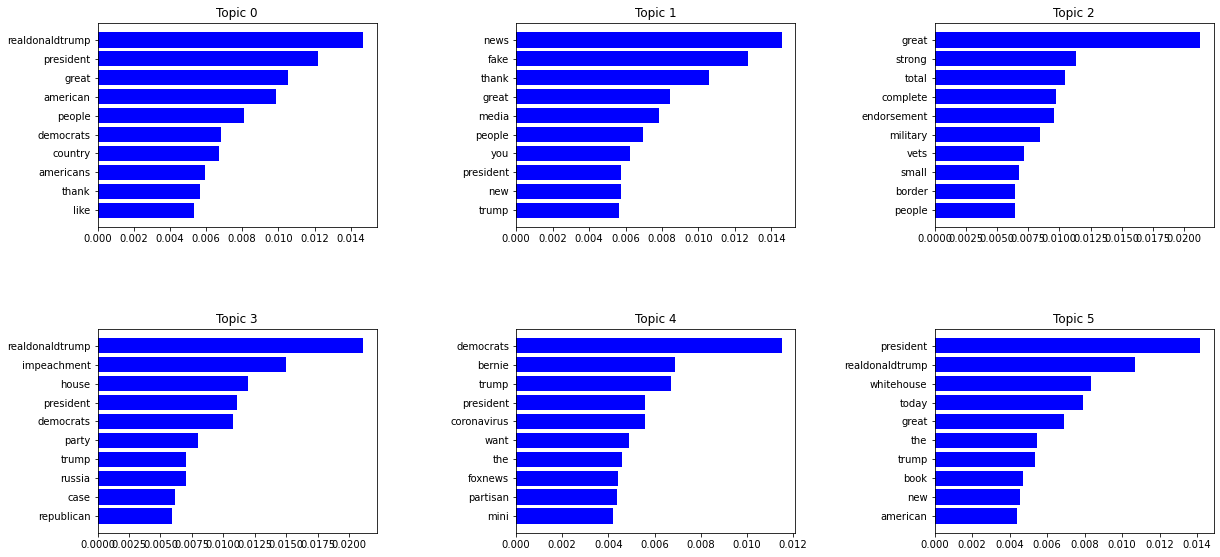

In [50]:
k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    gs = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()